In [21]:
# 사용한 라이브러리
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# GPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [99]:
# Data load
path_dir1 = 'dataset/train/rock_train/'
path_dir2 = 'dataset/train/paper/'
path_dir3 = 'dataset/train/scissors_train/'

file_list1 = os.listdir(path_dir1)  # path에 존재하는 파일 목록 가져오기
file_list2 = os.listdir(path_dir2)
file_list3 = os.listdir(path_dir3)

num = 0
X_train = np.float32(np.zeros((1800, 150, 150)))
y_train = np.int64(np.zeros((1800)))

for img_name in file_list1:
    img_path = path_dir1 + img_name
    img = mpimg.imread(img_path)/255.0
    x = np.array(img)
    X_train[num, :, :] = x

    y_train[num] = 0  # rock
    num = num + 1

for img_name in file_list2:
    img_path = path_dir2 + img_name
    img = mpimg.imread(img_path)/255.0
    x = np.array(img)
    X_train[num, :, :] = x

    y_train[num] = 1  # paper
    num = num + 1

for img_name in file_list3:
    img_path = path_dir3 + img_name
    img = mpimg.imread(img_path)/255.0
    x = np.array(img)
    X_train[num, :, :] = x

    y_train[num] = 2  # scissors
    num = num + 1


2


In [23]:
# Data shpae
X_train.shape, y_train.shape

((1800, 150, 150), (1800,))

In [24]:
# Data label
hand_pose_labels = ['rock', 'paper', 'scissors']

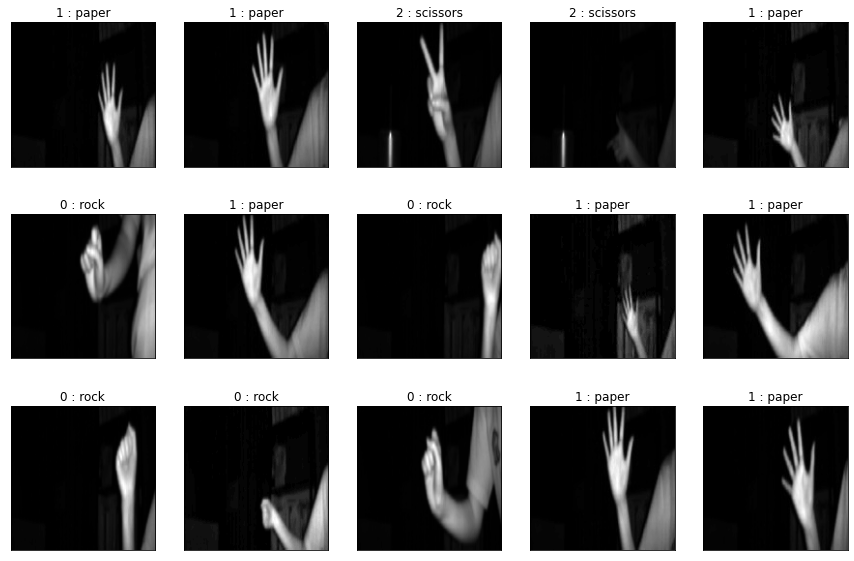

In [25]:
# Data visualization ver.1
figure = plt.figure(figsize=(15, 10))
for index, i in enumerate(np.random.randint(0, X_train.shape[0], 15)):
    ax = figure.add_subplot(3, 5, index + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap = 'gray')
    ax.set_title(f"{(y_train[i])} : {hand_pose_labels[y_train[i]]}")
plt.show()

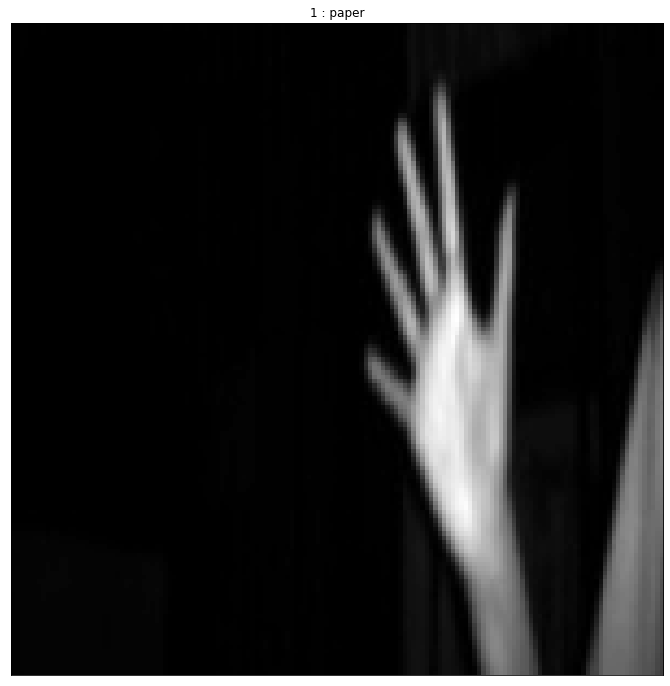

In [26]:
# Data visualization ver.2
plt.figure(figsize=(12,12))
plt.imshow(X_train[800], cmap ='gray')
plt.title(f'{y_train[800]} : {hand_pose_labels[y_train[800]]}')
plt.xticks([])
plt.yticks([])
plt.show()

In [27]:
# Data split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2, random_state = 87)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1440, 150, 150), (360, 150, 150), (1440,), (360,))

In [28]:
# Data split -> label & class가 동일한 비율
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 480, 1: 480, 2: 480}

In [29]:
# 0 - 1 Scale check
X_train.min(),  X_train.max()

(0.0, 1.0)

In [30]:
# Data preprocessing(one-hot encoding)
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 3)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, 3)

One-Hot encoding: 3이라고 표현된 라벨을 [0,0,1]과 같이 벡터로 바꿔줌
각 class별로 확률을 출력해야하기 때문에 필요한 작업

In [31]:
X_train_cnn = X_train.reshape(X_train.shape[0], 150, 150, 1)
X_valid_cnn = X_valid.reshape(X_valid.shape[0], 150, 150, 1)

# Model 설명
input size: (150, 150, 1)
마지막 layer의 softmax 활성화 함수: 3개의 노드에 대한 확률 출력 -> 가장 높은 값을 예측값으로 사용

In [32]:
cnn_model = tf.keras.Sequential([
    keras.layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (150, 150, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(), # Flaatten으로 이미지를 일차원으로 바꿔줌
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation = 'softmax')
])

In [113]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 150, 150, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        16448     
                                                                 
 batch_normalization_5 (Batc  (None, 75, 75, 64)      

In [33]:
# model compile
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001), metrics=['accuracy'])

In [34]:
# model training
checkpointer = ModelCheckpoint(filepath='model.weights.best.cnn.hdf5', verbose=0, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=3)
history = cnn_model.fit(X_train_cnn, y_train_one_hot, batch_size=2, epochs=15, verbose=1, validation_split=0.2, callbacks=[checkpointer, earlystopping])

Epoch 1/15
576/576 [==============================] - 34s 57ms/step - loss: 1.5466 - accuracy: 0.4497 - val_loss: 1.1624 - val_accuracy: 0.3368
Epoch 2/15
576/576 [==============================] - 33s 58ms/step - loss: 0.9997 - accuracy: 0.6241 - val_loss: 0.9334 - val_accuracy: 0.6389
Epoch 3/15
576/576 [==============================] - 33s 57ms/step - loss: 0.7460 - accuracy: 0.7483 - val_loss: 0.8197 - val_accuracy: 0.6806
Epoch 4/15
576/576 [==============================] - 33s 57ms/step - loss: 0.5154 - accuracy: 0.8273 - val_loss: 0.7929 - val_accuracy: 0.6806
Epoch 5/15
576/576 [==============================] - 33s 57ms/step - loss: 0.4567 - accuracy: 0.8368 - val_loss: 0.7033 - val_accuracy: 0.7014
Epoch 6/15
576/576 [==============================] - 33s 57ms/step - loss: 0.4192 - accuracy: 0.8646 - val_loss: 0.7276 - val_accuracy: 0.6840
Epoch 7/15
576/576 [==============================] - 33s 57ms/step - loss: 0.3338 - accuracy: 0.8845 - val_loss: 0.6160 - val_accuracy:

# Training 결과 확인

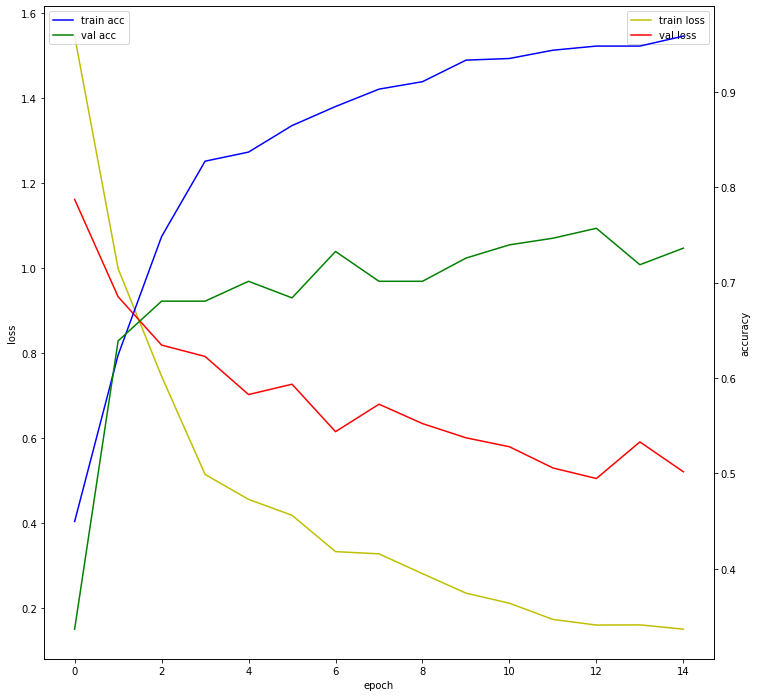

In [47]:
# Training Visualization
fig, loss_ax = plt.subplots(figsize=(12, 12))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

# Validation Data 검증

In [59]:
# 검증 - validation data
cnn_model.load_weights('model.weights.best.cnn.hdf5')
print('\nAccuracy: {:.4f}'.format(cnn_model.evaluate(X_valid_cnn, y_valid_one_hot)[1]))

12/12 [==============================] - 1s 67ms/step - loss: 0.4778 - accuracy: 0.7722

Accuracy: 0.7722


# Test Data 검증

In [106]:
# 검증 - test data load
test_dir1 = 'dataset/test/rock/'
test_dir2 = 'dataset/test/scissors/'

test_list1 = os.listdir(test_dir1)
test_list2 = os.listdir(test_dir2)

num = 0
X_test = np.float32(np.zeros((400, 150, 150)))
y_test = np.int64(np.zeros(400))

for img_name in test_list1:
    img_path = test_dir1 + img_name
    img = mpimg.imread(img_path)/255.0
    x = np.array(img)
    X_test[num, :, :] = x

    y_test[num] = 0  # test rock
    num = num + 1

for img_name in test_list2:
    img_path = test_dir2 + img_name
    img = mpimg.imread(img_path)/255.0
    x = np.array(img)
    X_test[num, :, :] = x

    y_test[num] = 2  # test scissors
    num = num + 1

X_test_cnn = X_test.reshape(X_test.shape[0], 150, 150, 1)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 3)

In [107]:
# 검증 - test data
cnn_model.predict(X_test_cnn)
print('\nAccuracy: {:.4f}'.format(cnn_model.evaluate(X_test_cnn, y_test_one_hot)[1]))

13/13 [==============================] - 1s 71ms/step - loss: 0.0849 - accuracy: 1.0000

Accuracy: 1.0000


(1, 150, 150)


array([[0.03164175, 0.01515403, 0.9532042 ]], dtype=float32)

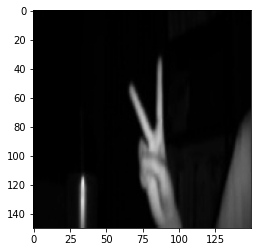

In [111]:
# load model - test
import numpy as np
img1=mpimg.imread('dataset/test/scissors/img124.jpg')/255.0
plt.imshow(img1, cmap='gray')
x1=np.array(img1)
x1=np.expand_dims(x1, axis=0)
print(x1.shape)
cnn_model.predict(x1)
#print(classes1)

# Model save

In [40]:
# model save(.h5)
cnn_model.save('model.cnn.h5')